In [19]:
import os
import numpy as np
from sklearn.metrics import f1_score
from skimage.io import imread
from skimage.transform import resize,rotate
from skimage.measure import find_contours
from skimage.util import invert
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
plt.style.use('default')
from keras.optimizers import SGD, Adam
import keras.backend as K
import keras
from keras import layers, activations
from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from IPython.display import Image
import tensorflow as tf
import Augmentor
import yaml
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator


In [20]:
train_x = []
train_y = []
test_x = []
test_y = []

####path
images_names_train=os.listdir('dataset-5.0/train/image/')#se considero dataset compuesto de tiles de
#https://projects.asl.ethz.ch/datasets/doku.php?id=weedmap:remotesensing2018weedmap
# este consta de 129 directorios y 18,746 archivos de imagen,en donde solo relacione 2000 muestra de entrenamiento y 500 de test
#leer readme
mask_names_train=os.listdir('dataset-5.0/train/annotation/')
############################################################
images_names_test=os.listdir('dataset-4.0/test/image/')
mask_names_test=os.listdir('dataset-4.0/test/annotation/')

In [21]:
images_names_train[1]#view names

'000_frame0033.png'

In [24]:
####dataset construct
for i in images_names_train:
    x_path = os.path.join('dataset-5.0/train/image/'+ i) 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    train_x.append(img)
for j in mask_names_train:
    y_path = os.path.join('dataset-5.0/train/annotation/'+ j) 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    y[:,:, 0] = weed
    y[:, :, 1] = crop
    
    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    
    train_y.append(y)
############################################################
for i in images_names_test:
    x_path = os.path.join('dataset-4.0/test/image/'+ i) 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    test_x.append(img)
for j in mask_names_test:
    y_path = os.path.join('dataset-4.0/test/annotation/'+ j) 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    y[:,:, 0] = weed
    y[:, :, 1] = crop
    
    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    
    test_y.append(y)

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
# en el caso de no disponer de gran cantidad de imagenes se dispone data aumentation
# en esta se debe considerar un seed para aumentar con la anotacion correspondiente a la imagen
# debe definirse no categorica. En caso de no considerar seed se sumara un error muy grande pues el true label
# de cada imagen sera diferrente. se debera entrenar a partir de un zip (contenedor)
def image_augme():
    data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=3,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow_from_directory(
        'dataset-5.0/train/image/',
        class_mode=None,
        seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
        'dataset-5.0/train/annotation/',
        class_mode=None,
        seed=seed)

# combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)

   

61475.0
133154.0
2164667


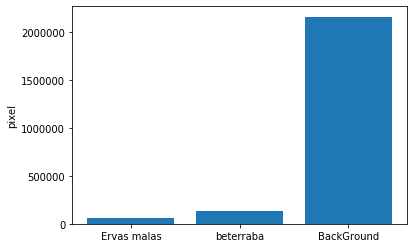

In [7]:
# un analisis del dataset que muestra que los datos estan desbalanceados
weed_pixel = 0
crop_pixel = 0
background_pixel = 0
for j in mask_names_train:
    y_path = os.path.join('dataset-5.0/train/annotation/'+ j) 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    weed = img[:,:,0]
    _pixel = np.sum(weed.flatten())
    weed_pixel += _pixel 
    crop = img[:,:,1]
    _pixel = np.sum(crop.flatten())
    crop_pixel += _pixel

    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1) * 1
    _pixel = np.sum(back.flatten())
    background_pixel += _pixel


print(weed_pixel)
print(crop_pixel)
print(background_pixel)

plt.bar(["Ervas malas","beterraba","BackGround"],[weed_pixel,crop_pixel,background_pixel])
plt.ylabel("pixel")
plt.savefig('pixel_wight.png')

In [8]:
#calculado la relacion de los pesos por pixel para cada clase
categorical_weight = [background_pixel/weed_pixel, background_pixel/crop_pixel, 1]
print(categorical_weight)

[35.21215128100854, 16.256867987443112, 1]


In [9]:
#se definio una funcion para la perdida, en donde se considero los pesos de los pixel
#esta escalara el calculo de la metrica segun la anterior consideracion
def weights_categorical_crossentropy(weights):
   
    if isinstance(weights,list) or isinstance(np.ndarray):
        weights=K.variable(weights)

    def loss(target,output,from_logits=False):
        if not from_logits:
            output /= tf.reduce_sum(output,
                                    len(output.get_shape()) - 1,
                                    True)
            _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
            weighted_losses = target * tf.log(output) * weights
            return - tf.reduce_sum(weighted_losses,len(output.get_shape()) - 1)
        else:
            raise ValueError('error')
    return loss

# def f1(y_true, y_pred):
#     def recall(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

#     def precision(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision
#     precision = precision(y_true, y_pred)
#     recall = recall(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
# def f1_scores(y_true, y_pred):
#     return f1_score(y_true, y_pred, labels=None, pos_label=1, average=None, sample_weight=None)
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)
def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    return K.mean(p)

def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    return K.mean(r)
    
    
    

In [10]:
#modelo u-net con camadas intemerdias entre blocks dropout(el dropout mejorara el comportamiento de la red ante escenario criticos)
#considerando que el comportamiento de esta debe ser generalizable y la co-adaptacion ocasionara que aprenda de mas los atributos
#y que la respuesta de nuestra cnn tienda a empeorar ante escenarios desconocidos
def model1(labels=1,h=128,w=128, out_activation = "sigmoid"):
    
    class MySoftmax(Layer):
        #http://cookie-box.hatenablog.com/entry/2017/08/15/231503 
        def __init__(self, **kwargs):
            super(MySoftmax, self).__init__(**kwargs)
        def call(self, x):
            return(activations.softmax(x, axis=3))
        
    #block1, 128x128
    inputs = layers.Input(shape=(h,w,3))
    conv11 = layers.Conv2D(8,(3,3),activation="relu",padding="same")(inputs)
    conv12= layers.Conv2D(8,(3,3),activation="relu",padding="same")(conv11)
    conv13= layers.Conv2D(8,(3,3),activation="relu",padding="same")(conv12)
    pool1 = layers.MaxPool2D((2,2))(conv13)
    drop1 = layers.Dropout(0.5)(pool1)
   #block2 64x64
    conv21 = layers.Conv2D(16,(3,3),activation="relu",padding="same")(drop1)
    conv22 = layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv21)
    conv23 = layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv22)
    pool2 = layers.MaxPool2D((2,2))(conv23)
    drop2 = layers.Dropout(0.5)(pool2)
    #block3 32x32
    conv31 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(drop2)
    conv32 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv31)
    conv33 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv32)
    pool3 = layers.MaxPool2D((2,2))(conv33)
    drop3 = layers.Dropout(0.3)(pool3)

    #block4 16x16
    conv41 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(drop3)
    conv42 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv41)
    conv43 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv42)
    pool4 = layers.MaxPool2D((2,2))(conv43)
    drop4 = layers.Dropout(0.3)(pool4)
    
    #bottom of Unet 8x8
    conv5 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(drop4)
    conv5 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv5)

    #upblock4
    x = layers.UpSampling2D((2,2))(conv5)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv43,x])
    x= layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.2)(x)
    #upblock3
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv33,x])
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.2)(x)
    #upblock2
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv23,x])
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #upblock1
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv13,x])
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #to label image (2 labels)
    x = layers.Conv2D(labels,(1,1))(x)
    outputs = layers.Activation("relu")(x)#sigmoid 
    model = Model(inputs=inputs,outputs=outputs)
    return model

In [11]:
K.clear_session()

#def dice_coef(y_true, y_pred):
#    y_true = K.flatten(y_true)
#    y_pred = K.flatten(y_pred)
#    intersection = K.sum(y_true * y_pred)
#    return (2.0 * intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

#def dice_coef_loss(y_true, y_pred):
#    return 1 - dice_coef(y_true, y_pred)
#considrea la funcion de perdida para el entrenamiento, junto a un optimizar adam debido a sus grandes beneficios.
custom_loss = weights_categorical_crossentropy(categorical_weight)


model=model1(labels=3,out_activation="relu")
l = layers.Reshape((128*128,3))(model.output)
outs = layers.Activation("softmax")(l)
#debe tenerse en consideracion la metrica f1 score la cual relacionara la precision y recall (se segmenta todos los objetos? con que precision?=f1 score)
model = Model(inputs=model.input,outputs=outs)
lr = 1e-3
adam = Adam(lr = lr)
model.compile(loss=custom_loss,optimizer=adam,metrics=['accuracy',f1,precision,recall,mean_iou])

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 8)  584         conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

conv2d_22 (Conv2D)              (None, 64, 64, 32)   13856       concatenate_3[0][0]              
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_22[0][0]                  
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 64, 64, 32)   0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 128, 128, 32) 0           dropout_7[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 16) 4624        up_sampling2d_4[0][0]            
__________________________________________________________________________________________________
concatenat

In [13]:
#se considera un conjunto de validacion y un early stoping para monitorear el comportamiento de la red durante
#la etapa de entrenamiento
print('Start the training')
#file_name = 'best_model.h5'
#checkpointer = ModelCheckpoint(file_name, monitor='val_acc', save_best_only=True)
early_stop = EarlyStopping(monitor = f1, min_delta = 0.0001, 
                               mode = 'max', patience = 100)
history = model.fit(train_x, train_y, batch_size=80, epochs=500, 
                    verbose=0,validation_split=0.2,callbacks=[early_stop])
#aplicar si se aumentan los datos:
#history=model.fit_generator( #train_generator,
  #      sbatch_size=80, epochs=1000, 
                    #verbose=0,validation_split=0.20,callbacks=[early_stop])

#del model
#model = load_model(file_name)

Start the training


In [43]:
# Guarda el modelo junto a los pesos
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_b.h5")
print("Saved model to disk")


Saved model to disk


In [15]:
#carga el modelo junto a sus pesos
json_file = open('model_b.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.compile(loss=custom_loss,optimizer=adam,metrics=['accuracy',f1,precision,recall,mean_iou])
# load weights into new model
loaded_model.load_weights("model_b.h5")
print("Loaded model from disk")


Loaded model from disk


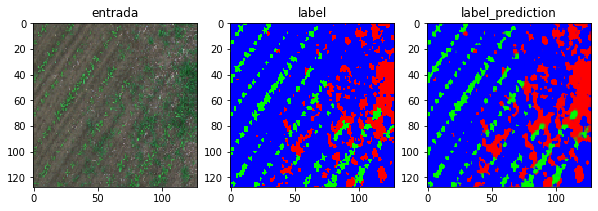

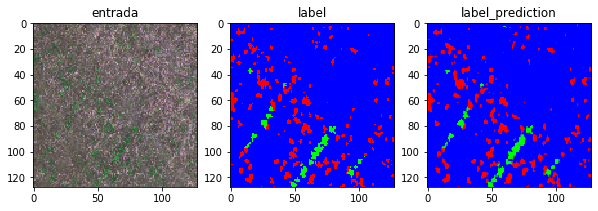

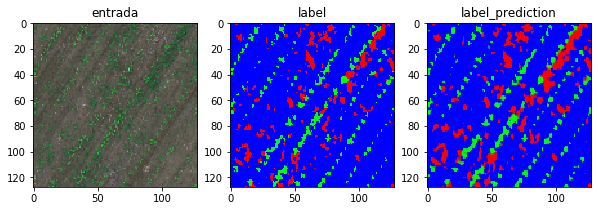

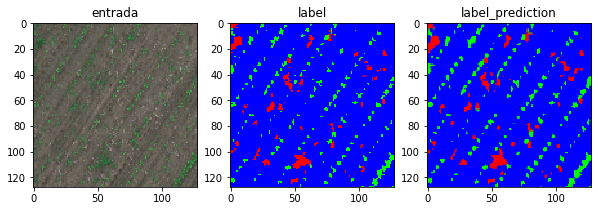

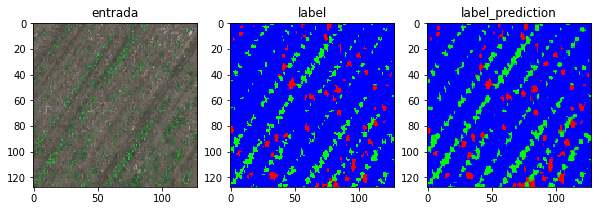

In [17]:
#evaluacion qualitativa
#ciclo que muestra la salida de nuestra red respecto a segmentacion semantica

for i in range (5):
    n=i
    plt.figure(figsize=(10,8))
    plt.subplot(2,3,1)
    plt.title("entrada")
    plt.imshow(test_x[n])

    plt.subplot(2,3,2)
    plt.title("label")
    img = np.reshape(test_y[n, :],(128,128,3))
    plt.imshow(img)

    prediction = loaded_model.predict(test_x[n:n+1])
    prediction = np.reshape(prediction,(128,128,3))
#prediction = np.argmax(prediction, axis=2)
    plt.subplot(2,3,3)
    plt.title("label_prediction")
    plt.imshow(prediction)
    
    plt.savefig('model_best_n:'+str(n)+'.png')

global metrics

In [136]:
#loss,acc,f1,precision,recall,mean_iou = loaded_model.evaluate(test_x,test_y, verbose=1)

In [137]:
#print('loss_ts:',loss,'f1:',f1,'mean_iou:',mean_iou,'acc:',acc) #global metrics

Clases metrics

In [ ]:
#calculo de metricas
#considerar un batch custom, o total de preferencia
for a in range(10): #(80)

#y_pred=model.predict(test_x[1])
    y_true= test_y[a:a+1].reshape(128,128,3)
    y_true
#y_true.shape
    y_true=np.argmax(y_true, axis=2)
#y_true=y_true.reshape(16384, 3)
    y_true = np.reshape(y_true,(128*128))

#f1_m=f1(y_true, y_pred)
    y_pred = loaded_model.predict(test_x[a:a+1])
    y_pred=y_pred.reshape(16384, 3)
    y_pred = np.reshape(y_pred,(128,128,3))
    y_pred = np.argmax(y_pred, axis=2)
    y_pred = np.reshape(y_pred,(128*128))
    from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
    F1_list=f1_score(y_pred, y_true,average=None)
    precision=precision_score(y_pred, y_true,average=None)
    recall_score=recall_score(y_pred, y_true,average=None)
  #  print('F1:',F1_list,'precision:',precision)#,'recall_score:',recall_score)
    ##F1_list=[]
#for i in range(100):
    
#F1_list=f1_score(y_pred, y_true,average=None)
#precision=precision_score(y_pred, y_true,average=None)
#recall_score=recall_score(y_pred, y_true,average=None)
#print('F1:',F1_list,'precision:',precision,'recall_score:',recall_score)